In [ ]:
### VISUALIZE THE H5 FILE WE WILL USE ###

In [1]:
import h5py

def list_contents(h5_file):
    with h5py.File(h5_file, 'r') as file:
        print("Listing all groups and datasets within the file:")
        file.visititems(print_name_and_info)

def print_name_and_info(name, obj):
    if isinstance(obj, h5py.Dataset):
        print(f"Dataset: {name} - Shape: {obj.shape}, Dtype: {obj.dtype}")
    else:
        print(f"Group: {name}")

def check_data_in_h5(file_path):
    with h5py.File(file_path, 'r') as f:
        for name in f:
            print(name, f[name]['true_vol'][:].sum())  # Check if the volume contains non-zero values

def view_dataset(h5_file, dataset_path):
    with h5py.File(h5_file, 'r') as file:
        if dataset_path in file:
            data = file[dataset_path][()]
            print(f"Data from {dataset_path}:")
            print(data)
        else:
            print(f"Dataset {dataset_path} not found in file.")

h5_file = 'cryo_data_rmsd.h5'
#check_data_in_h5('cryo_data.h5')

# List all groups and datasets
list_contents(h5_file)

# View specific dataset (replace 'group/dataset' with actual path in your H5 file)
view_dataset(h5_file, 'group/dataset')


Listing all groups and datasets within the file:
Group: 2Y9J_backbone
Dataset: 2Y9J_backbone/homolog_ca - Shape: (64, 64, 64), Dtype: float32
Dataset: 2Y9J_backbone/true_ca - Shape: (64, 64, 64), Dtype: float32
Dataset: 2Y9J_backbone/true_vol - Shape: (64, 64, 64), Dtype: float32
Group: 2YEW_backbone
Dataset: 2YEW_backbone/homolog_ca - Shape: (64, 64, 64), Dtype: float32
Dataset: 2YEW_backbone/true_ca - Shape: (64, 64, 64), Dtype: float32
Dataset: 2YEW_backbone/true_vol - Shape: (64, 64, 64), Dtype: float32
Group: 3IXV_backbone
Dataset: 3IXV_backbone/homolog_ca - Shape: (64, 64, 64), Dtype: float32
Dataset: 3IXV_backbone/true_ca - Shape: (64, 64, 64), Dtype: float32
Dataset: 3IXV_backbone/true_vol - Shape: (64, 64, 64), Dtype: float32
Group: 3IYJ_backbone
Dataset: 3IYJ_backbone/homolog_ca - Shape: (64, 64, 64), Dtype: float32
Dataset: 3IYJ_backbone/true_ca - Shape: (64, 64, 64), Dtype: float32
Dataset: 3IYJ_backbone/true_vol - Shape: (64, 64, 64), Dtype: float32
Group: 3IZI_backbone
Da

In [ ]:
### START HERE ###

In [1]:
import torch
from torch.utils.data import Dataset
import h5py

class CryoData(Dataset):
    def __init__(self, h5_file):
        self.h5_file = h5_file
        with h5py.File(self.h5_file, 'r') as file:
            self.keys = list(file.keys())

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as file:
            group = file[self.keys[idx]]
            true_ca = torch.tensor(group['true_ca'][:])
            homolog_ca = torch.tensor(group['homolog_ca'][:])
            true_vol = torch.tensor(group['true_vol'][:])
        return {'true_ca': true_ca, 'homolog_ca': homolog_ca, 'true_vol': true_vol}

# Usage example
dataset = CryoData('cryo_data_rmsd.h5')

# Assuming you have a CryoData instance called 'dataset'
for i in range(3):  # Check the first three samples
    sample = dataset[i]
    print(f"Sample {i}:")
    print(f"homolog_ca shape: {sample['homolog_ca'].shape}")
    print(f"true_vol shape: {sample['true_vol'].shape}")
    print(f"true_ca shape: {sample['true_ca'].shape}")
    print(f"homolog_ca stats: min={sample['homolog_ca'].min()}, max={sample['homolog_ca'].max()}")
    print(f"true_vol stats: min={sample['true_vol'].min()}, max={sample['true_vol'].max()}")
    print(f"true_ca stats: min={sample['true_ca'].min()}, max={sample['true_ca'].max()}")
    print()


Sample 0:
homolog_ca shape: torch.Size([64, 64, 64])
true_vol shape: torch.Size([64, 64, 64])
true_ca shape: torch.Size([64, 64, 64])
homolog_ca stats: min=0.0, max=1.0
true_vol stats: min=0.0, max=1.0
true_ca stats: min=0.0, max=1.0

Sample 1:
homolog_ca shape: torch.Size([64, 64, 64])
true_vol shape: torch.Size([64, 64, 64])
true_ca shape: torch.Size([64, 64, 64])
homolog_ca stats: min=0.0, max=1.0
true_vol stats: min=0.0, max=1.0
true_ca stats: min=0.0, max=1.0

Sample 2:
homolog_ca shape: torch.Size([64, 64, 64])
true_vol shape: torch.Size([64, 64, 64])
true_ca shape: torch.Size([64, 64, 64])
homolog_ca stats: min=0.0, max=1.0
true_vol stats: min=0.0, max=1.0
true_ca stats: min=0.0, max=1.0



In [2]:
import torch
from torch.utils.data import DataLoader, random_split

dataset_size = len(dataset)
train_size = int(0.9 * dataset_size)  # 90% for training
test_size = dataset_size - train_size  # 10% for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Data loaders for both train and test sets
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

for batch in train_loader:
    print(f"Batch homolog_ca shape: {batch['homolog_ca'].shape}")
    print(f"Batch true_vol shape: {batch['true_vol'].shape}")
    print(f"Batch true_ca shape: {batch['true_ca'].shape}")
    break;

Batch homolog_ca shape: torch.Size([1, 64, 64, 64])
Batch true_vol shape: torch.Size([1, 64, 64, 64])
Batch true_ca shape: torch.Size([1, 64, 64, 64])


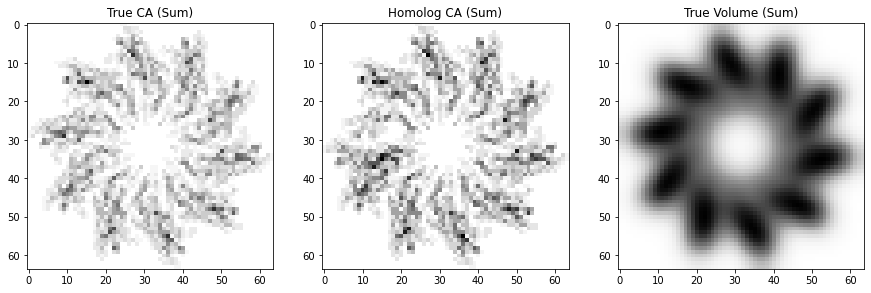

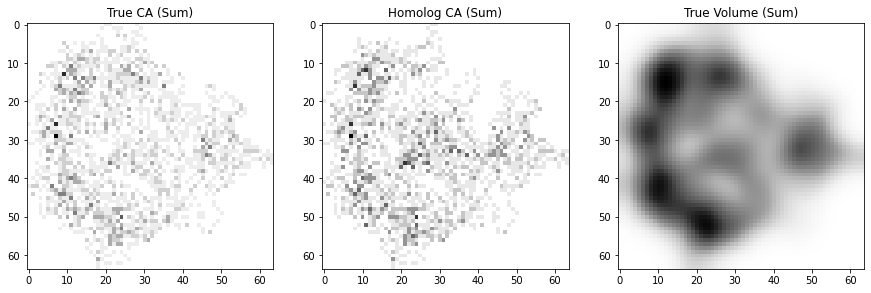

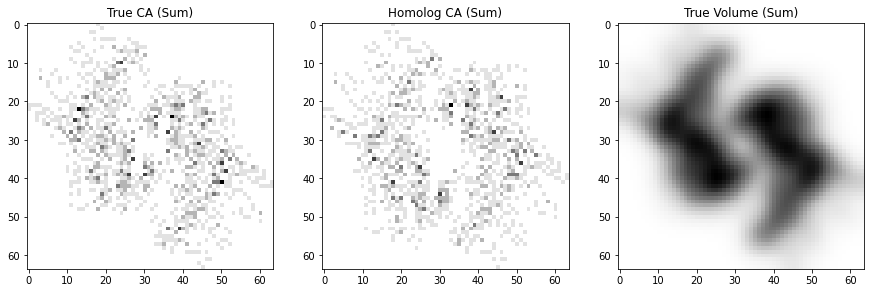

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_data(loader, num_batches=1, start_layer=0, end_layer=63):
    for i, batch in enumerate(loader):
        if i >= num_batches:
            break
        true_ca = batch['true_ca'].numpy()
        homolog_ca = batch['homolog_ca'].numpy()
        true_vol = batch['true_vol'].numpy()

        # Take the sum over the specified range of layers
        true_ca_sum = np.sum(true_ca[:, :, :, start_layer:end_layer+1], axis=3)
        homolog_ca_sum = np.sum(homolog_ca[:, :, :, start_layer:end_layer+1], axis=3)
        true_vol_sum = np.sum(true_vol[:, :, :, start_layer:end_layer+1], axis=3)

        # Visualize the sum over layers
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(true_ca_sum[0], cmap='Greys')
        ax[0].set_title('True CA (Sum)')
        ax[1].imshow(homolog_ca_sum[0], cmap='Greys')
        ax[1].set_title('Homolog CA (Sum)')
        ax[2].imshow(true_vol_sum[0], cmap='Greys')
        ax[2].set_title('True Volume (Sum)')
        plt.show()

# Visualize some data from the train loader
visualize_data(train_loader, num_batches=3)


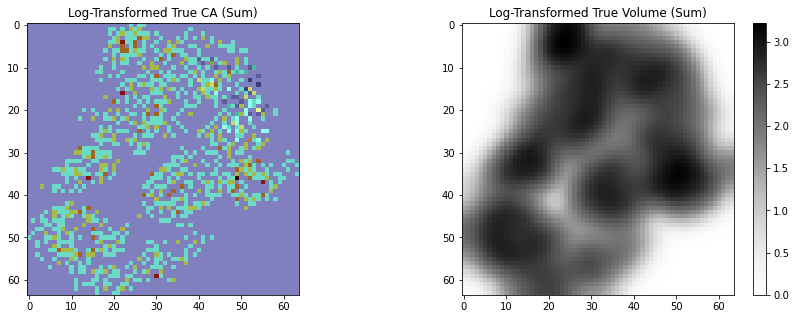

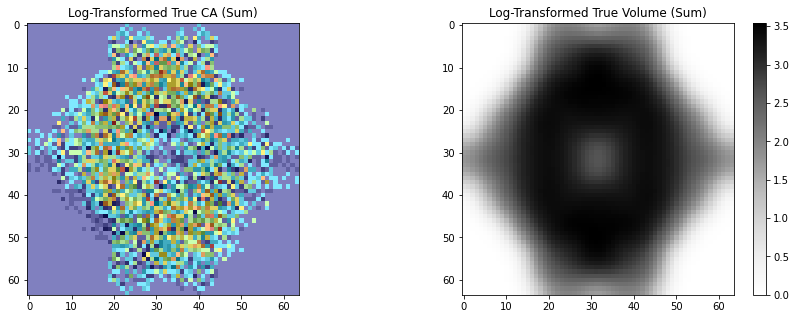

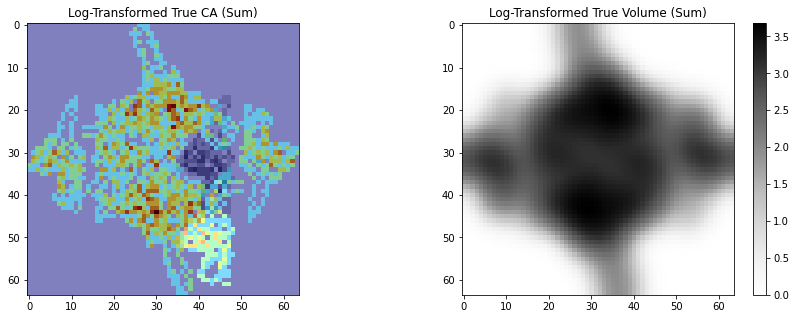

In [6]:
def visualize_data(loader, num_batches=1, start_layer=0, end_layer=63):
    for i, batch in enumerate(loader):
        if i >= num_batches:
            break
        true_ca = batch['true_ca'].numpy()
        homolog_ca = batch['homolog_ca'].numpy()
        true_vol = batch['true_vol'].numpy()

        # Take the sum over the specified range of layers
        true_ca_sum = np.sum(true_ca[:, :, :, start_layer:end_layer+1], axis=3)
        homolog_ca_sum = np.sum(homolog_ca[:, :, :, start_layer:end_layer+1], axis=3)
        true_vol_sum = np.sum(true_vol[:, :, :, start_layer:end_layer+1], axis=3)

        # Apply logarithmic transformation to the data
        true_ca_sum_log = np.log(true_ca_sum + 1)  # Add 1 to avoid log(0)
        homolog_ca_sum_log = np.log(homolog_ca_sum + 1)  # Add 1 to avoid log(0)
        true_vol_sum_log = np.log(true_vol_sum + 1)  # Add 1 to avoid log(0)

        # Create a new figure
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))

        # Visualize the log-transformed True CA (sum) with a colormap
        ax[0].imshow(true_ca_sum_log[0], cmap='Greys')
        ax[0].set_title('Log-Transformed True CA (Sum)')

        # Overlay the log-transformed Homolog CA graph on top of True CA with a different colormap
        ax[0].imshow(homolog_ca_sum_log[0], cmap='jet', alpha=0.5)

        # Visualize the log-transformed True Volume (sum)
        ax[1].imshow(true_vol_sum_log[0], cmap='Greys')
        ax[1].set_title('Log-Transformed True Volume (Sum)')

        # Add a colorbar to the plot to indicate the color mapping
        plt.colorbar(ax[1].imshow(true_vol_sum_log[0], cmap='Greys'), ax=ax[1])

        # Show the plot
        plt.show()


# Visualize some data from the train loader
visualize_data(train_loader, num_batches=3)

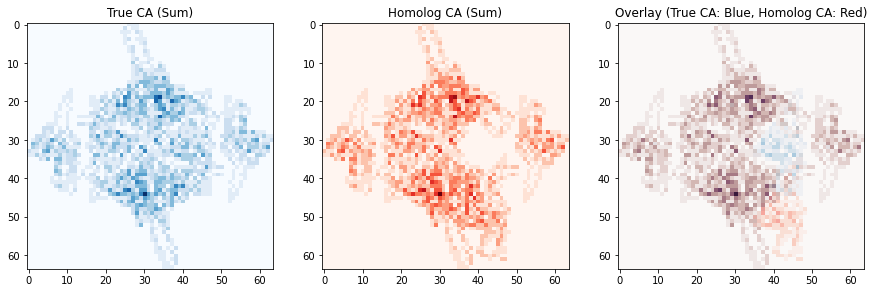

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_data(loader, num_batches=1, start_layer=0, end_layer=63):
    for i, batch in enumerate(loader):
        if i >= num_batches:
            break
        true_ca = batch['true_ca'].numpy()
        homolog_ca = batch['homolog_ca'].numpy()
        true_vol = batch['true_vol'].numpy()

        # Take the sum over the specified range of layers
        true_ca_sum = np.sum(true_ca[:, :, :, start_layer:end_layer+1], axis=3)
        homolog_ca_sum = np.sum(homolog_ca[:, :, :, start_layer:end_layer+1], axis=3)
        true_vol_sum = np.sum(true_vol[:, :, :, start_layer:end_layer+1], axis=3)

        # Create a new figure
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        # Visualize True CA
        ax[0].imshow(true_ca_sum[0], cmap='Blues')
        ax[0].set_title('True CA (Sum)')

        # Visualize Homolog CA
        ax[1].imshow(homolog_ca_sum[0], cmap='Reds')
        ax[1].set_title('Homolog CA (Sum)')

        # Overlay True CA and Homolog CA
        ax[2].imshow(true_ca_sum[0], cmap='Blues')
        ax[2].imshow(homolog_ca_sum[0], cmap='Reds', alpha=0.5)
        ax[2].set_title('Overlay (True CA: Blue, Homolog CA: Red)')

        # Show the plot
        plt.show()

# Example usage
visualize_data(train_loader)


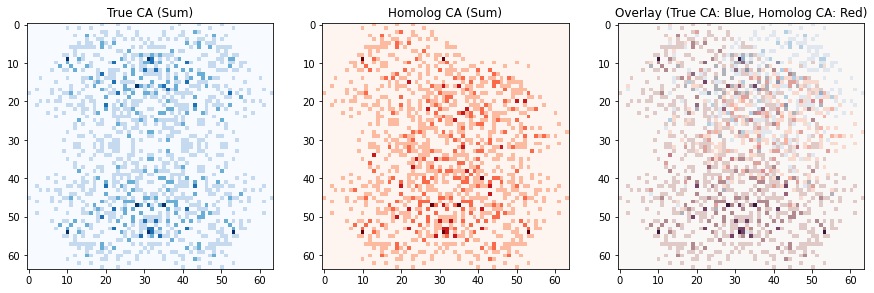

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_data(loader, num_batches=1, start_layer=0, end_layer=63):
    for i, batch in enumerate(loader):
        if i >= num_batches:
            break
        true_ca = batch['true_ca'].numpy()
        homolog_ca = batch['homolog_ca'].numpy()
        true_vol = batch['true_vol'].numpy()

        # Take the sum over the specified range of layers
        true_ca_sum = np.sum(true_ca[:, :, :, start_layer:end_layer+1], axis=3)
        homolog_ca_sum = np.sum(homolog_ca[:, :, :, start_layer:end_layer+1], axis=3)
        true_vol_sum = np.sum(true_vol[:, :, :, start_layer:end_layer+1], axis=3)

        # Create a new figure
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        # Visualize True CA
        ax[0].imshow(true_ca_sum[0], cmap='Blues')
        ax[0].set_title('True CA (Sum)')

        # Visualize Homolog CA
        ax[1].imshow(homolog_ca_sum[0], cmap='Reds')
        ax[1].set_title('Homolog CA (Sum)')

        # Overlay True CA and Homolog CA
        ax[2].imshow(true_ca_sum[0], cmap='Blues')
        ax[2].imshow(homolog_ca_sum[0], cmap='Reds', alpha=0.5)
        ax[2].set_title('Overlay (True CA: Blue, Homolog CA: Red)')

        # Show the plot
        plt.show()

# Example usage
visualize_data(train_loader)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Define the encoder path (downsampling)
        self.down_conv1 = self.contract_block(2, 64, 3, 1)
        self.down_conv2 = self.contract_block(64, 128, 3, 1)
        self.down_conv3 = self.contract_block(128, 256, 3, 1)
        self.down_conv4 = self.contract_block(256, 512, 3, 1)

        # Define the decoder path (upsampling)
        self.up_conv4 = self.expand_block(512, 256, 3, 1)
        self.up_conv3 = self.expand_block(256*2, 128, 3, 1)
        self.up_conv2 = self.expand_block(128*2, 64, 3, 1)
        self.up_conv1 = self.expand_block(64*2, 64, 3, 1)

        # Final output layer
        self.final_conv = nn.Conv3d(64, 1, kernel_size=3, padding=1)

        self.relu = nn.ReLU(inplace=True)
        self.bn = nn.BatchNorm3d(1)

        # Additional convolutional layer
        self.conv64 = nn.Conv3d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=1)
        self.sigmoid = nn.Sigmoid()

    
    def __call__(self, x):
        # Encoder pathway
        x1 = self.down_conv1(x)
        x2 = self.down_conv2(F.max_pool3d(x1, kernel_size=2, stride=2))
        x3 = self.down_conv3(F.max_pool3d(x2, kernel_size=2, stride=2))
        x4 = self.down_conv4(F.max_pool3d(x3, kernel_size=2, stride=2))

        # Decoder pathway
        x = self.up_conv4(F.interpolate(x4, scale_factor=2))
        x = self.up_conv3(F.interpolate(torch.cat((x, x3), 1), scale_factor=2))
        x = self.up_conv2(F.interpolate(torch.cat((x, x2), 1), scale_factor=2))
        x = self.up_conv1(F.interpolate(torch.cat((x, x1), 1), scale_factor=2))

        # Final output
        x = self.final_conv(x)
        x = self.relu(x)
        x = self.bn(x)
        x = self.conv64(x)
        x = self.sigmoid(x)
        return x

    def contract_block(self, in_channels, out_channels, kernel_size, padding):
        contract = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(out_channels),
            nn.Conv3d(out_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(out_channels)
        )
        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):
        expand = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(out_channels),
            nn.Conv3d(out_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(out_channels)
        )
        return expand

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

model = UNet().to(device)

Using device: cuda


In [5]:
from torchsummary import summary

# Print the model summary
summary(model, (2, 64, 64, 64))  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 64, 64, 64, 64]           3,520
              ReLU-2       [-1, 64, 64, 64, 64]               0
       BatchNorm3d-3       [-1, 64, 64, 64, 64]             128
            Conv3d-4       [-1, 64, 64, 64, 64]         110,656
              ReLU-5       [-1, 64, 64, 64, 64]               0
       BatchNorm3d-6       [-1, 64, 64, 64, 64]             128
            Conv3d-7      [-1, 128, 32, 32, 32]         221,312
              ReLU-8      [-1, 128, 32, 32, 32]               0
       BatchNorm3d-9      [-1, 128, 32, 32, 32]             256
           Conv3d-10      [-1, 128, 32, 32, 32]         442,496
             ReLU-11      [-1, 128, 32, 32, 32]               0
      BatchNorm3d-12      [-1, 128, 32, 32, 32]             256
           Conv3d-13      [-1, 256, 16, 16, 16]         884,992
             ReLU-14      [-1, 256, 16,

In [6]:
import torch

def calculate_fsc(volume1, volume2, num_shells):
    # Compute the Fourier Transforms
    fft_vol1 = torch.fft.fftn(volume1)
    fft_vol2 = torch.fft.fftn(volume2)

    # Shift zero frequency to the center
    fft_vol1_shifted = torch.fft.fftshift(fft_vol1)
    fft_vol2_shifted = torch.fft.fftshift(fft_vol2)

    # Compute radii of each voxel
    center = torch.tensor(volume1.shape) // 2
    kx, ky, kz = torch.meshgrid(torch.arange(volume1.shape[0]), torch.arange(volume1.shape[1]), torch.arange(volume1.shape[2]), indexing='ij')
    radii = torch.sqrt((kx - center[0])**2 + (ky - center[1])**2 + (kz - center[2])**2)
    max_radius = torch.max(radii)

    # Initialize FSC
    fsc = torch.zeros(num_shells, device=volume1.device)

    # Calculate FSC for each shell
    shell_indices = torch.round((radii / max_radius) * num_shells).long()
    for i in range(num_shells):
        mask = (shell_indices == i)
        num_voxels = mask.sum()

        if num_voxels > 0:
            corr = torch.sum(torch.conj(fft_vol1_shifted[mask]) * fft_vol2_shifted[mask])
            vol1_power = torch.sum(torch.abs(fft_vol1_shifted[mask])**2)
            vol2_power = torch.sum(torch.abs(fft_vol2_shifted[mask])**2)
            fsc[i] = torch.abs(corr) / torch.sqrt(vol1_power * vol2_power)

    return fsc



In [9]:
# compute the loss given volumes
def fsc_loss_function(prediction, target, num_shells=20):
    fsc_values = calculate_fsc(prediction, target, num_shells)
    fsc = fsc_values.mean()  # Mean of all FSC values across shells
    return 1.0 - fsc  # Assuming we want to minimize the loss (1 - FSC)


In [19]:
num_epochs = 25
print(f"Number of Epochs to Run: {num_epochs}")

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
fsc_loss_train_values = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    for i, batch in enumerate(train_loader):
        homolog_ca = batch['homolog_ca'].to(device)
        true_vol = batch['true_vol'].to(device)
        true_ca = batch['true_ca'].to(device)

        # Stack the arrays along a new dimension to create a tensor of shape 2x64x64x64
        inputs = torch.stack((homolog_ca, true_vol), dim=1)
        #print(f"Input shape: {inputs.shape}")
        
        optimizer.zero_grad()
        outputs = model(inputs)

        # Compute the predictions corresponding to the homolog_ca array
        homolog_ca_predictions = outputs[:, :1, :, :, :]  # Assuming the predictions are in the first channel
       
        fsc_loss_value = fsc_loss_function(homolog_ca_predictions, true_ca.unsqueeze(1))
        fsc_loss_value.backward()
        optimizer.step()

        fsc_loss_train_values.append(fsc_loss_value.item())
        # Log the training loss
        print(f"Epoch {epoch+1}/{num_epochs}, Step {i+1}/{len(train_loader)} FSC: {fsc_loss_value.item()}")
    print(f"Number of Epochs Left to Run: {num_epochs-(epoch+1)}")
    print(f"Average FSC: {np.array(fsc_loss_train_values).mean()}")
    

Number of Epochs to Run: 25
Epoch 1/25, Step 1/230 FSC: 0.953033983707428
Epoch 1/25, Step 2/230 FSC: 0.9227407574653625
Epoch 1/25, Step 3/230 FSC: 0.9291529059410095
Epoch 1/25, Step 4/230 FSC: 0.926162600517273
Epoch 1/25, Step 5/230 FSC: 0.8867427706718445
Epoch 1/25, Step 6/230 FSC: 0.8558483719825745
Epoch 1/25, Step 7/230 FSC: 0.886796236038208
Epoch 1/25, Step 8/230 FSC: 0.9214159846305847
Epoch 1/25, Step 9/230 FSC: 0.7407550811767578
Epoch 1/25, Step 10/230 FSC: 0.867620587348938
Epoch 1/25, Step 11/230 FSC: 0.6885965466499329
Epoch 1/25, Step 12/230 FSC: 0.6912683844566345
Epoch 1/25, Step 13/230 FSC: 0.9031589031219482
Epoch 1/25, Step 14/230 FSC: 0.8762677311897278
Epoch 1/25, Step 15/230 FSC: 0.5185149908065796
Epoch 1/25, Step 16/230 FSC: 0.7764319181442261
Epoch 1/25, Step 17/230 FSC: 0.9043506383895874
Epoch 1/25, Step 18/230 FSC: 0.43241292238235474
Epoch 1/25, Step 19/230 FSC: 0.8962591290473938
Epoch 1/25, Step 20/230 FSC: 0.322848379611969
Epoch 1/25, Step 21/230 F

Length of Test set: 26
Avg FSC of Test set: 0.272934037905473


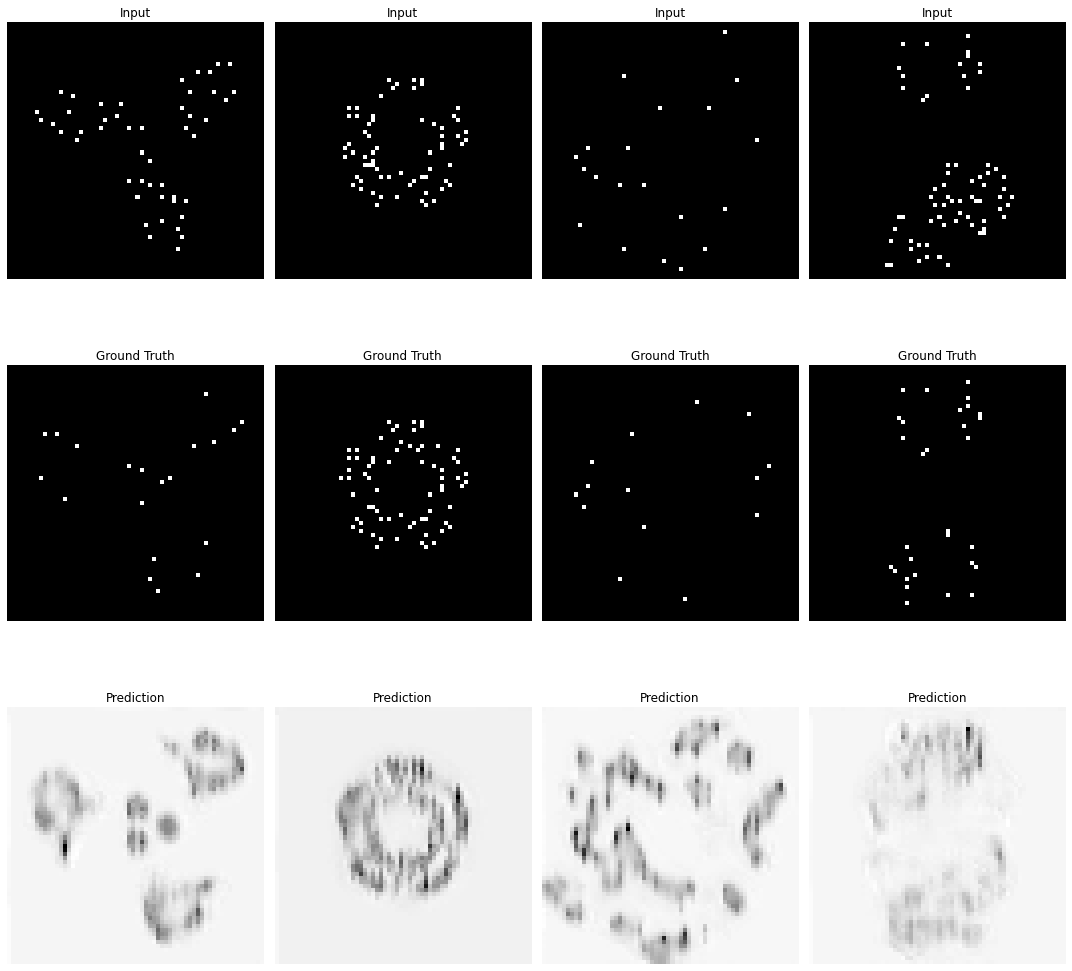

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
model.eval()

# Initialize lists to store inputs, ground truth, and predictions
inputs_list = []
predictions_list = []
ground_truth_list = []
fsc_values_test = []

# Iterate over the test data
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        homolog_ca = batch['homolog_ca'].to(device)
        true_vol = batch['true_vol'].to(device)
        true_ca = batch['true_ca'].to(device)

        inputs = torch.stack((homolog_ca, true_vol), dim=1)
        
        # Forward pass
        outputs = model(inputs)

        # Compute the predictions corresponding to the homolog_ca array
        homolog_ca_predictions = outputs[:, :1, :, :, :]  # Assuming the predictions are in the first channel
        fsc_loss_value = fsc_loss_function(homolog_ca_predictions, true_ca.unsqueeze(1))
        
        # Append inputs, ground truth, and predictions to the lists
        inputs_list.append(inputs.cpu().numpy())
        predictions_list.append(outputs.cpu().numpy())
        ground_truth_list.append(true_ca.cpu().numpy())
        fsc_values_test.append(fsc_loss_value.item())
        
# Convert lists to NumPy arrays
inputs_array = np.concatenate(inputs_list, axis=0)
predictions_array = np.concatenate(predictions_list, axis=0)
ground_truth_array = np.concatenate(ground_truth_list, axis=0)
#fsc_vals = np.concatenate(fsc_values_test, axis=0)

    
length = len(ground_truth_array)
print(f'Length of Test set: {length}')
print(f'Avg FSC of Test set: {(np.array(fsc_values_test).mean()-1)/-1}')

# Visualize the input data, ground truth, and predictions
# Example visualization code (modify as needed)
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15,15))

for i in range(4):
    axes[0, i].imshow(inputs_array[i, 0, :, :, 32], cmap='gray')  # Show the input slice
    axes[0, i].set_title('Input')
    axes[0, i].axis('off')

    axes[1, i].imshow(ground_truth_array[i, :, :, 32], cmap='gray')  # Show the ground truth slice
    axes[1, i].set_title('Ground Truth')
    axes[1, i].axis('off')

    axes[2, i].imshow(predictions_array[i, 0, :, :, 32], cmap='gray')  # Show the prediction slice
    axes[2, i].set_title('Prediction')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()


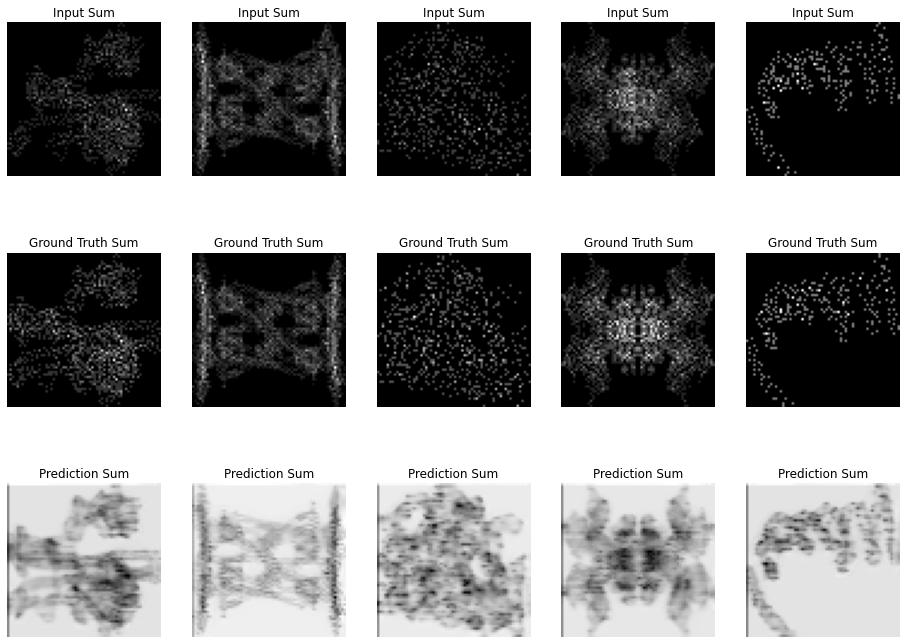

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def plot_slices_with_sum(inputs_array, ground_truth_array, predictions_array, start_layer=0, end_layer=63):
    fig, ax = plt.subplots(3, 5, figsize=(16, 12))

    for i, (input, gt, preds) in enumerate(zip(inputs_array, ground_truth_array, predictions_array)):    
        
        # Perform summation along the depth axis
        input_sum = np.sum(input[0], axis=0)
        true_sum = np.sum(gt, axis=0)
        pred_sum = np.sum(np.sum(preds, axis=0), axis=0)

        # Plot the summed slices
        ax[0, i].imshow(input_sum, cmap='gray')  # Select a slice along the depth axis
        ax[0, i].set_title('Input Sum')
        ax[0, i].axis('off')

        ax[1, i].imshow(true_sum, cmap='gray')  # Select a slice along the depth axis
        ax[1, i].set_title('Ground Truth Sum')
        ax[1, i].axis('off')

        ax[2, i].imshow(pred_sum, cmap='gray')  # Select a slice along the depth axis
        ax[2, i].set_title('Prediction Sum')
        ax[2, i].axis('off')
   
        if i == 4:
            break

    plt.show()
    
# Example usage
plot_slices_with_sum(inputs_array, ground_truth_array, predictions_array)


In [ ]:
### Overfit?

In [ ]:
### Check the training dataset predictions

230


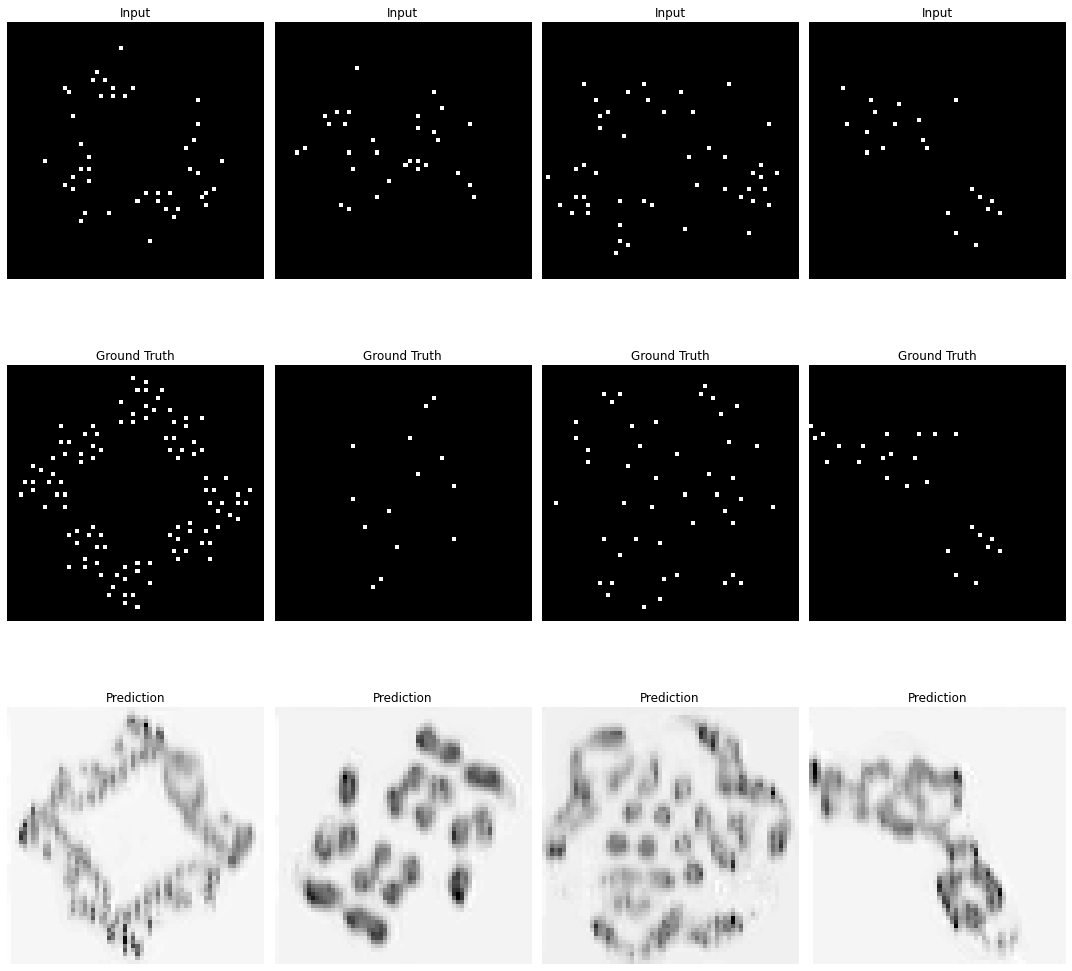

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
model.eval()

# Initialize lists to store inputs, ground truth, and predictions
inputs_list_train = []
predictions_list_train = []
ground_truth_list_train = []

# Iterate over the test data
with torch.no_grad():
    for i, batch in enumerate(train_loader):
        homolog_ca = batch['homolog_ca'].to(device)
        true_vol = batch['true_vol'].to(device)
        true_ca = batch['true_ca'].to(device)

        inputs_train = torch.stack((homolog_ca, true_vol), dim=1)
        
        # Forward pass
        outputs_train = model(inputs_train)

        # Append inputs, ground truth, and predictions to the lists
        inputs_list_train.append(inputs_train.cpu().numpy())
        predictions_list_train.append(outputs_train.cpu().numpy())
        ground_truth_list_train.append(true_ca.cpu().numpy())

# Convert lists to NumPy arrays
inputs_array_train = np.concatenate(inputs_list_train, axis=0)
predictions_array_train = np.concatenate(predictions_list_train, axis=0)
ground_truth_array_train = np.concatenate(ground_truth_list_train, axis=0)

length_train = len(ground_truth_array_train)
print(length_train)

# Visualize the input data, ground truth, and predictions
# Example visualization code (modify as needed)
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15,15))

for i in range(4):
    axes[0, i].imshow(inputs_array_train[i, 0, :, :, 32], cmap='gray')  # Show the input slice
    axes[0, i].set_title('Input')
    axes[0, i].axis('off')

    axes[1, i].imshow(ground_truth_array_train[i, :, :, 32], cmap='gray')  # Show the ground truth slice
    axes[1, i].set_title('Ground Truth')
    axes[1, i].axis('off')

    axes[2, i].imshow(predictions_array_train[i, 0, :, :, 32], cmap='gray')  # Show the prediction slice
    axes[2, i].set_title('Prediction')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()


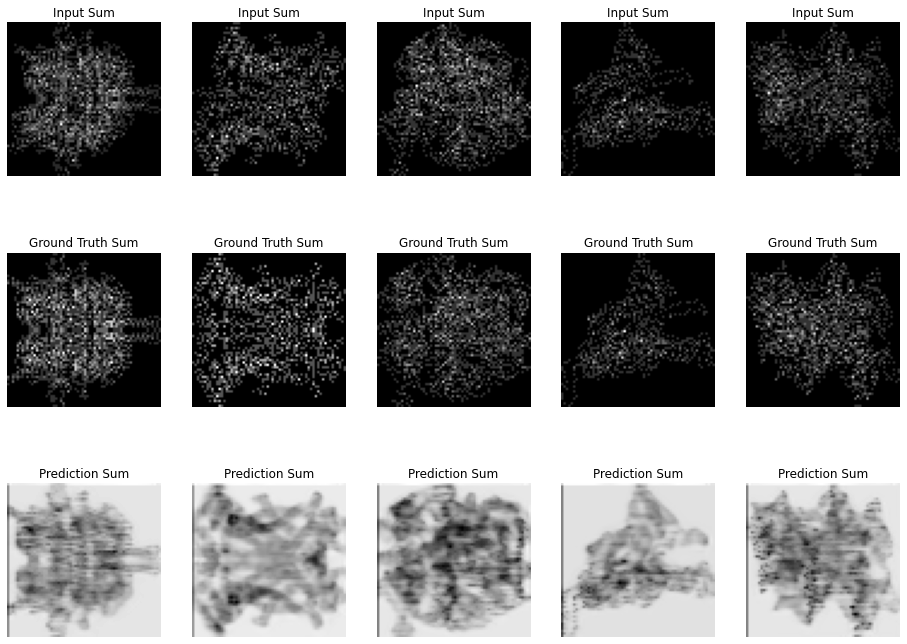

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def plot_slices_with_sum(inputs_array, ground_truth_array, predictions_array, start_layer=0, end_layer=63):
    fig, ax = plt.subplots(3, 5, figsize=(16, 12))

    for i, (input, gt, preds) in enumerate(zip(inputs_array, ground_truth_array, predictions_array)):    
        
        # Perform summation along the depth axis
        input_sum = np.sum(input[0], axis=0)
        true_sum = np.sum(gt, axis=0)
        pred_sum = np.sum(np.sum(preds, axis=0), axis=0)

        # Plot the summed slices
        ax[0, i].imshow(input_sum, cmap='gray')  # Select a slice along the depth axis
        ax[0, i].set_title('Input Sum')
        ax[0, i].axis('off')

        ax[1, i].imshow(true_sum, cmap='gray')  # Select a slice along the depth axis
        ax[1, i].set_title('Ground Truth Sum')
        ax[1, i].axis('off')

        ax[2, i].imshow(pred_sum, cmap='gray')  # Select a slice along the depth axis
        ax[2, i].set_title('Prediction Sum')
        ax[2, i].axis('off')
   
        if i == 4:
            break

    plt.show()
    
# Example usage
plot_slices_with_sum(inputs_array_train, ground_truth_array_train, predictions_array_train)
